In [1]:
#https://github.com/olgaliak/detection-amlworkbench/tree/master/assets
#!wget https://olgalicodestory.blob.core.windows.net/kittiwakedata/kittiwake_labled.zip
#!unzip kittiwake_labled.zip
#!rm kittiwake_labled.zip

In [43]:
import os
import glob
import json
import numpy as np
import torchvision
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
# Bit messy to use chainercv to visualise ...
from chainercv.visualizations import vis_bbox  # todo

In [3]:
PATH = "kittiwake_labled/"

In [4]:
with open(os.path.join(PATH, "train.json"), 'r') as annofile:
    labels = json.load(annofile) 

In [5]:
class BirdsData(Dataset):
    
    def __init__(self, img_dir, lbl_file, transform=None):
        self.img_locs = glob.glob(os.path.join(img_dir, "*.JPG"))
        with open(lbl_file, 'r') as annofile:
            self.labels = json.load(annofile) 
        self.transform = transform
        print("Loaded {} images".format(len(self.img_locs)))
        
    def __getitem__(self, idx):
        im_file = self.img_locs[idx]

        # BBoxes fixed to w=1269,h=952
        # Resized before transform to match label
        im_rgb = Image.open(im_file).resize((1269, 952))
        
        # Bounding boxes: (y_{min}, x_{min}, y_{max}, x_{max}
        img_no = str(int(os.path.basename(
            os.path.splitext(im_file)[0])))
        labels = self.labels['frames'][img_no]
        # 'ymin', 'xmin', 'ymax', 'xmax'
        bboxes = np.array([
            (l['y1'], l['x1'], l['y2'], l['x2']) for l in labels])
        
        # Class labels (start at 0)
        cls_label = np.zeros(len(bboxes))
        
        if self.transform is not None:
            im_rgb = self.transform(im_rgb)
        return im_rgb, torch.FloatTensor(bboxes), torch.FloatTensor(cls_label), 1
        
    def __len__(self):
        return len(self.img_locs)

In [6]:
# Init dataset
train_dataset = BirdsData(
    img_dir = os.path.join(PATH, "train"),
    lbl_file = os.path.join(PATH, "train.json"))

Loaded 160 images


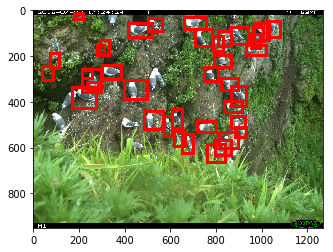

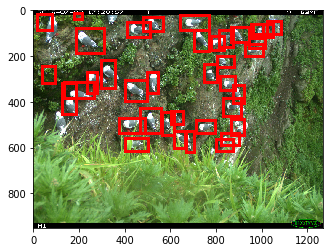

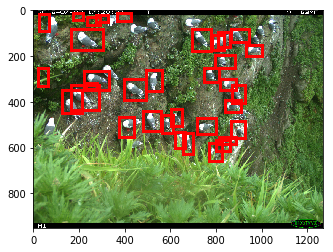

In [7]:
# Visualise rndm images
for i in [5, 16, 55]:
    im, boxes, cls_lab, scale = train_dataset[i]
    im_array = np.moveaxis(np.array(im),-1,0)
    vis_bbox(im_array, boxes)

## 1. Faster-RCNN

In [9]:
# Model specific imports
from model.faster_rcnn import FasterRCNN
from model.region_proposal_network import RegionProposalNetwork
from model.faster_rcnn_vgg16 import VGG16RoIHead, decom_vgg16
# Training imports
import torchvision.transforms as transforms
from tqdm import tqdm
from trainer import FasterRCNNTrainer
from utils import array_tool as at
# Test prediction
from model.utils.bbox_tools import loc2bbox
from model.utils.nms import non_maximum_suppression
import cupy as cp
from torch.nn import functional as F

/home/iliauk/simple-faster-rcnn-pytorch/model/utils/nms/non_maximum_suppression.py:12: UserWarning: 
    the python code for non_maximum_suppression is about 2x slow
    It is strongly recommended to build cython code: 
    `cd model/utils/nms/; python3 build.py build_ext --inplace
  `cd model/utils/nms/; python3 build.py build_ext --inplace''')


In [10]:
# Normalise by imagenet mean/sd
IMAGENET_RGB_MEAN = [0.485, 0.456, 0.406]
IMAGENET_RGB_SD = [0.229, 0.224, 0.225]

normalize = transforms.Normalize(IMAGENET_RGB_MEAN,
                                 IMAGENET_RGB_SD)

img_trans = transforms.Compose([transforms.ToTensor(), normalize])

# Init dataset
train_dataset = BirdsData(
    img_dir = os.path.join(PATH, "train"),
    lbl_file = os.path.join(PATH, "train.json"), 
    transform=img_trans)

# Loader
dataloader = DataLoader(train_dataset, 
                        batch_size=1,
                        shuffle=True)

Loaded 160 images


In [11]:
# Model: Default using VGG16
class FasterRCNNVGG16(FasterRCNN):

    # VGG specific
    feat_stride = 16  # downsample 16x for output of conv5 in vgg16

    def __init__(self,
                 n_fg_class=1,
                 ratios=[0.5, 1, 2],
                 anchor_scales=[8, 16, 32]):
                 
        # Note that vgg16 is used for backbone and classifier 
        extractor, classifier = decom_vgg16()
        #print("Backbone: ", extractor)
        
        rpn = RegionProposalNetwork(
            512, 512,
            ratios=ratios,
            anchor_scales=anchor_scales,
            feat_stride=self.feat_stride)
        print("Region Proposal Network: ", rpn)

        head = VGG16RoIHead(
            n_class=n_fg_class + 1,
            roi_size=7,
            spatial_scale=(1. / self.feat_stride),
            classifier=classifier)
        print("Head: ", head)
        
        super(FasterRCNNVGG16, self).__init__(
            extractor,
            rpn,
            head)

In [12]:
# Initiate model
faster_rcnn = FasterRCNNVGG16()

Region Proposal Network:  RegionProposalNetwork(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (score): Conv2d(512, 18, kernel_size=(1, 1), stride=(1, 1))
  (loc): Conv2d(512, 36, kernel_size=(1, 1), stride=(1, 1))
)
Head:  VGG16RoIHead(
  (classifier): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=4096, out_features=4096, bias=True)
    (3): ReLU(inplace)
  )
  (cls_loc): Linear(in_features=4096, out_features=8, bias=True)
  (score): Linear(in_features=4096, out_features=2, bias=True)
  (roi): RoIPooling2D()
)


In [13]:
# Initiate trainer with model
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

In [14]:
def try_prediction(img_arr, verbose=True):
    # Eval mode
    trainer.faster_rcnn.eval()
    
    # Forward pass only
    h = trainer.faster_rcnn.extractor(img_arr)
    rpn_locs, rpn_scores, rois, roi_indices, anchor = trainer.faster_rcnn.rpn(
        h, img_arr.shape[2:], 1)
    roi_cls_loc, roi_scores =  trainer.faster_rcnn.head(
        h, rois, roi_indices)
       
    if verbose:
        print("roi_cls_loc {}, roi_scores {}, rois {}".format(
            roi_cls_loc.shape, roi_scores.shape, rois.shape))
    scale = 1 
    # We are assuming that batch size is 1.
    roi_score = roi_scores.data
    roi_cls_loc = roi_cls_loc.data
    roi = at.totensor(rois) / scale
    
    # Convert predictions to bounding boxes in image coordinates.
    # Bounding boxes are scaled to the scale of the input images.
    mean = torch.Tensor(trainer.faster_rcnn.loc_normalize_mean).cuda(). \
        repeat(trainer.faster_rcnn.n_class)[None]
    std = torch.Tensor(trainer.faster_rcnn.loc_normalize_std).cuda(). \
        repeat(trainer.faster_rcnn.n_class)[None]
    
    roi_cls_loc = (roi_cls_loc * std + mean)
    roi_cls_loc = roi_cls_loc.view(-1, trainer.faster_rcnn.n_class, 4)
    roi = roi.view(-1, 1, 4).expand_as(roi_cls_loc)
    cls_bbox = loc2bbox(at.tonumpy(roi).reshape((-1, 4)),
                        at.tonumpy(roi_cls_loc).reshape((-1, 4)))
    cls_bbox = at.totensor(cls_bbox)
    cls_bbox = cls_bbox.view(-1, trainer.faster_rcnn.n_class * 4)
    # clip bounding box
    cls_bbox[:, 0::2] = (cls_bbox[:, 0::2]).clamp(min=0, max=1269)
    cls_bbox[:, 1::2] = (cls_bbox[:, 1::2]).clamp(min=0, max=1269)
    
    prob = at.tonumpy(F.softmax(roi_score, dim=-1))

    raw_cls_bbox = at.tonumpy(cls_bbox)  # 300, 
    print("raw_cls_bbox {}".format(raw_cls_bbox.shape))
    raw_prob = at.tonumpy(prob)
    print("raw_prob {}".format(raw_prob.shape))

    pred_bbox, pred_label, pred_score = trainer.faster_rcnn._suppress(raw_cls_bbox, raw_prob)
    print("pred_bbox {}, pred_label {}, pred_score {}".format(
        pred_bbox.shape, pred_label.shape, pred_score.shape))
    
    return pred_bbox, pred_label, pred_score

In [15]:
def viz_predict_eval_image(input_image, augment=False):
    # Input image
    test_im = Image.open(input_image).resize((1269, 952))
    # Augment?
    if augment:
        test_im = img_aug(test_im)
    # Transforms   
    test_arr = img_trans(test_im)
    test_arr = torch.Tensor(np.expand_dims(test_arr, axis=0))
    test_arr = test_arr.cuda()
    # Predict on image
    pred_bbox, pred_label, pred_score = try_prediction(test_arr)
    # Visualise
    vis_bbox(np.moveaxis(np.array(test_im),-1,0), pred_bbox)
    return len(pred_bbox)

roi_cls_loc torch.Size([300, 8]), roi_scores torch.Size([300, 2]), rois (300, 4)
raw_cls_bbox (300, 8)
raw_prob (300, 2)
pred_bbox (69, 4), pred_label (69,), pred_score (69,)


69

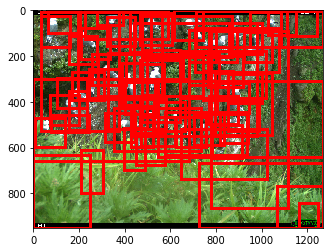

In [16]:
# Predict random image untrained
viz_predict_eval_image('kittiwake_labled/test/255.JPG')

In [17]:
# Train one-epoch
for epoch in range(10):
    print("Epoch {}".format(epoch+1))
    for ii, (img, bbox_, label_, scale) in tqdm(enumerate(dataloader)):
        #scale (float): Amount of scaling applied to the raw image during preprocessing
        scale = at.scalar(scale)
        img, bbox, label = img.cuda().float(), bbox_.cuda(), label_.cuda()
        trainer.train_step(img, bbox, label, scale)
        if ii % 100 == 0:
            print(ii, trainer.get_meter_data())

0it [00:00, ?it/s]

Epoch 1


1it [00:00,  2.20it/s]

0 {'roi_cls_loss': 0.9010112285614014, 'rpn_loc_loss': 0.8086400032043457, 'total_loss': 2.4570980072021484, 'roi_loc_loss': 0.040444280952215195, 'rpn_cls_loss': 0.707002580165863}


101it [00:48,  2.10it/s]

100 {'roi_cls_loss': 0.4905848588683816, 'rpn_loc_loss': 0.3375564871153029, 'total_loss': 1.6732213910263363, 'roi_loc_loss': 0.32960318600629834, 'rpn_cls_loss': 0.5154768497046857}


160it [01:15,  2.11it/s]
0it [00:00, ?it/s]

Epoch 2


1it [00:00,  2.31it/s]

0 {'roi_cls_loss': 0.48754812564168637, 'rpn_loc_loss': 0.32734673937655395, 'total_loss': 1.6204045285349309, 'roi_loc_loss': 0.3501433330061647, 'rpn_cls_loss': 0.45536632678523536}


101it [00:45,  2.22it/s]

100 {'roi_cls_loss': 0.4713282250581571, 'rpn_loc_loss': 0.28858874144453656, 'total_loss': 1.4975185223009395, 'roi_loc_loss': 0.3541126280480649, 'rpn_cls_loss': 0.38348892916322186}


160it [01:11,  2.23it/s]
0it [00:00, ?it/s]

Epoch 3


1it [00:00,  2.18it/s]

0 {'roi_cls_loss': 0.46714562112668573, 'rpn_loc_loss': 0.28737085667726064, 'total_loss': 1.4734830750483214, 'roi_loc_loss': 0.35241940632648194, 'rpn_cls_loss': 0.36654719234534133}


101it [00:45,  2.24it/s]

100 {'roi_cls_loss': 0.4556039368596607, 'rpn_loc_loss': 0.2731987793449837, 'total_loss': 1.4099023783858196, 'roi_loc_loss': 0.3468900602266654, 'rpn_cls_loss': 0.33420960208724027}


160it [01:11,  2.23it/s]
0it [00:00, ?it/s]

Epoch 4


1it [00:00,  2.23it/s]

0 {'roi_cls_loss': 0.45172567544756703, 'rpn_loc_loss': 0.26687158638003483, 'total_loss': 1.385424164005723, 'roi_loc_loss': 0.34482070807514736, 'rpn_cls_loss': 0.3220061934601491}


101it [00:44,  2.26it/s]

100 {'roi_cls_loss': 0.44392616874995217, 'rpn_loc_loss': 0.2534356520939203, 'total_loss': 1.3367678911878793, 'roi_loc_loss': 0.3404994317989243, 'rpn_cls_loss': 0.29890663900032716}


160it [01:10,  2.27it/s]
0it [00:00, ?it/s]

Epoch 5


1it [00:00,  2.31it/s]

0 {'roi_cls_loss': 0.4418329646732431, 'rpn_loc_loss': 0.2538082095650541, 'total_loss': 1.3287756289595174, 'roi_loc_loss': 0.3391348591565437, 'rpn_cls_loss': 0.2939995963957492}


101it [00:45,  2.21it/s]

100 {'roi_cls_loss': 0.43662855622337254, 'rpn_loc_loss': 0.25199002516173163, 'total_loss': 1.3089248449535325, 'roi_loc_loss': 0.3361973211762474, 'rpn_cls_loss': 0.2841089428496744}


160it [01:11,  2.25it/s]
0it [00:00, ?it/s]

Epoch 6


1it [00:00,  2.27it/s]

0 {'roi_cls_loss': 0.4341104088093012, 'rpn_loc_loss': 0.24534642123402134, 'total_loss': 1.2898389542296262, 'roi_loc_loss': 0.3344371038141395, 'rpn_cls_loss': 0.2759450208046907}


101it [00:45,  2.24it/s]

100 {'roi_cls_loss': 0.4285338842015421, 'rpn_loc_loss': 0.24434274941120507, 'total_loss': 1.2704474922687161, 'roi_loc_loss': 0.3309374984217336, 'rpn_cls_loss': 0.26663336131337173}


160it [01:10,  2.27it/s]
0it [00:00, ?it/s]

Epoch 7


1it [00:00,  2.29it/s]

0 {'roi_cls_loss': 0.42646505316946204, 'rpn_loc_loss': 0.23909233665553137, 'total_loss': 1.2543515898558637, 'roi_loc_loss': 0.32947881721758676, 'rpn_cls_loss': 0.2593153836854907}


101it [00:44,  2.25it/s]

100 {'roi_cls_loss': 0.42259670603005683, 'rpn_loc_loss': 0.2364879337180682, 'total_loss': 1.238868239856239, 'roi_loc_loss': 0.3264503791106689, 'rpn_cls_loss': 0.25333322156975535}


160it [01:10,  2.26it/s]
0it [00:00, ?it/s]

Epoch 8


1it [00:00,  2.22it/s]

0 {'roi_cls_loss': 0.4212148847402369, 'rpn_loc_loss': 0.23434084996807045, 'total_loss': 1.2308572253194061, 'roi_loc_loss': 0.32520263729472404, 'rpn_cls_loss': 0.2500988535722589}


101it [00:45,  2.23it/s]

100 {'roi_cls_loss': 0.41787743708767183, 'rpn_loc_loss': 0.22915468880575657, 'total_loss': 1.2120697132687803, 'roi_loc_loss': 0.32230399084337674, 'rpn_cls_loss': 0.24273359678520884}


160it [01:12,  2.20it/s]
0it [00:00, ?it/s]

Epoch 9


1it [00:00,  2.47it/s]

0 {'roi_cls_loss': 0.4159899643745211, 'rpn_loc_loss': 0.23016268178343674, 'total_loss': 1.2080923634334813, 'roi_loc_loss': 0.3210853002907287, 'rpn_cls_loss': 0.24085441741228636}


101it [00:44,  2.28it/s]

100 {'roi_cls_loss': 0.4127724987389301, 'rpn_loc_loss': 0.22766451924974537, 'total_loss': 1.1940851670343926, 'roi_loc_loss': 0.3184347142917921, 'rpn_cls_loss': 0.23521343527994304}


160it [01:10,  2.28it/s]
0it [00:00, ?it/s]

Epoch 10


1it [00:00,  2.22it/s]

0 {'roi_cls_loss': 0.4112182117786616, 'rpn_loc_loss': 0.22652240468242105, 'total_loss': 1.188417976470064, 'roi_loc_loss': 0.3172405604027485, 'rpn_cls_loss': 0.2334368003145799}


101it [00:44,  2.26it/s]

100 {'roi_cls_loss': 0.4083168909949662, 'rpn_loc_loss': 0.22488274001730948, 'total_loss': 1.1780031973243479, 'roi_loc_loss': 0.31537979240979497, 'rpn_cls_loss': 0.22942377494903116}


160it [01:10,  2.28it/s]


roi_cls_loc torch.Size([300, 8]), roi_scores torch.Size([300, 2]), rois (300, 4)
raw_cls_bbox (300, 8)
raw_prob (300, 2)
pred_bbox (39, 4), pred_label (39,), pred_score (39,)


39

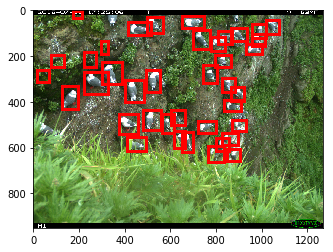

In [18]:
# Try again
viz_predict_eval_image('kittiwake_labled/test/213.JPG')

roi_cls_loc torch.Size([300, 8]), roi_scores torch.Size([300, 2]), rois (300, 4)
raw_cls_bbox (300, 8)
raw_prob (300, 2)
pred_bbox (42, 4), pred_label (42,), pred_score (42,)


42

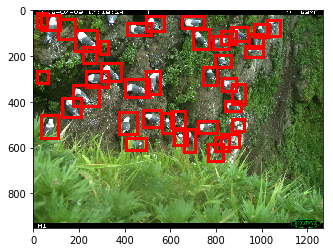

In [19]:
# Try again
viz_predict_eval_image('kittiwake_labled/test/222.JPG')

In [20]:
# Make things more difficult
img_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3)])

roi_cls_loc torch.Size([300, 8]), roi_scores torch.Size([300, 2]), rois (300, 4)
raw_cls_bbox (300, 8)
raw_prob (300, 2)
pred_bbox (38, 4), pred_label (38,), pred_score (38,)


38

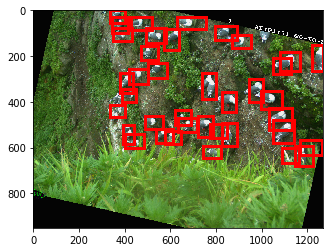

In [21]:
viz_predict_eval_image('kittiwake_labled/test/222.JPG', augment=True)

roi_cls_loc torch.Size([300, 8]), roi_scores torch.Size([300, 2]), rois (300, 4)
raw_cls_bbox (300, 8)
raw_prob (300, 2)
pred_bbox (43, 4), pred_label (43,), pred_score (43,)


43

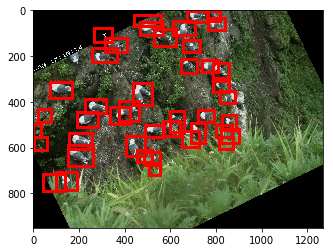

In [22]:
viz_predict_eval_image('kittiwake_labled/test/222.JPG', augment=True)

roi_cls_loc torch.Size([300, 8]), roi_scores torch.Size([300, 2]), rois (300, 4)
raw_cls_bbox (300, 8)
raw_prob (300, 2)
pred_bbox (40, 4), pred_label (40,), pred_score (40,)


40

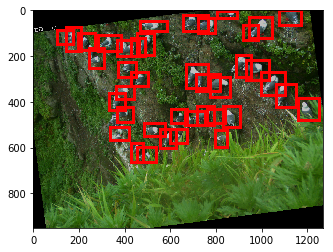

In [23]:
viz_predict_eval_image('kittiwake_labled/test/222.JPG', augment=True)

roi_cls_loc torch.Size([300, 8]), roi_scores torch.Size([300, 2]), rois (300, 4)
raw_cls_bbox (300, 8)
raw_prob (300, 2)
pred_bbox (47, 4), pred_label (47,), pred_score (47,)


47

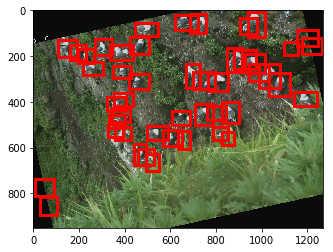

In [24]:
viz_predict_eval_image('kittiwake_labled/test/222.JPG', augment=True)

## 2. RPN Forward-Pass

Ref: https://medium.com/@fractaldle/guide-to-build-faster-rcnn-in-pytorch-95b10c273439

Need to just remove from ROI from loss when back-prop

```
LossTuple = namedtuple('LossTuple',
                       ['rpn_loc_loss',
                        'rpn_cls_loss',
                        'roi_loc_loss',
                        'roi_cls_loss',
                        'total_loss'
                        ])```

In [44]:
# PARAMS
n_pre_nms = 6000
n_post_nms= 300
min_size = 16
nms_thresh = 0.3
score_thresh = 0.97

In [45]:
# Sample image
loc_img = 'kittiwake_labled/test/222.JPG'
input_img = Image.open(loc_img).resize((1269, 952))
# Transform to array
test_arr = img_trans(input_img)
test_arr = torch.Tensor(np.expand_dims(test_arr, axis=0))
test_arr = test_arr.cuda()

In [46]:
trainer.faster_rcnn.eval()
# Pass img through CNN backbone
features = trainer.faster_rcnn.extractor(test_arr)
# Feature vector
print(features.shape)  # torch.Size([1, 512, 59, 79])

torch.Size([1, 512, 59, 79])


In [47]:
# Pass features through RPN
print(trainer.faster_rcnn.rpn)
img_size, scale = (952, 1269), 1  # img_size is opposite of PIL
rpn_locs, rpn_scores, rois, roi_indices, anchor = \
            trainer.faster_rcnn.rpn(features, img_size, scale)

RegionProposalNetwork(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (score): Conv2d(512, 18, kernel_size=(1, 1), stride=(1, 1))
  (loc): Conv2d(512, 36, kernel_size=(1, 1), stride=(1, 1))
)


In [48]:
# Corresponding scores for top RPs (foreground)
test_scores = at.tonumpy(F.softmax(np.squeeze(rpn_scores.data), dim=1))
test_scores = np.squeeze(test_scores)[:,1]  # fore-ground class

In [49]:
# Proposal creator creates ROIs
# rpn_locs (offsets) + anchor = rois; this method more control over rois

# Convert anchors into proposal via bbox transformation
test_roi = loc2bbox(anchor, rpn_locs[0].cpu().data.numpy())

# Clip predicted boxes to image.
test_roi[:, slice(0, 4, 2)] = np.clip(
    test_roi[:, slice(0, 4, 2)], 0, img_size[0])
test_roi[:, slice(1, 4, 2)] = np.clip(
    test_roi[:, slice(1, 4, 2)], 0, img_size[1])

# Remove predicted boxes with either height or width < threshold.
hs = test_roi[:, 2] - test_roi[:, 0]
ws = test_roi[:, 3] - test_roi[:, 1]
keep = np.where((hs >= min_size) & (ws >= min_size))[0]
test_roi = test_roi[keep, :]
test_scores = test_scores[keep]

# Sort by score
order = test_scores.ravel().argsort()[::-1]
order = order[:n_pre_nms]
test_roi = test_roi[order, :]
test_scores = test_scores[order] 

# Mask
mask = test_scores > score_thresh
test_scores = test_scores[mask]
test_roi = test_roi[mask]
  
# Apply nms
keep = non_maximum_suppression(
    cp.ascontiguousarray(cp.asarray(test_roi)),
    nms_thresh,
    test_scores)

print(len(keep))
# Keep not all
keep = keep[:n_post_nms]
test_roi = test_roi[keep]

43


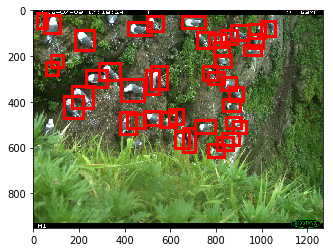

In [50]:
# Visualise the ROIs
vis_bbox(np.moveaxis(np.array(input_img),-1,0), test_roi)
# This need a bit of non max supression

roi_cls_loc torch.Size([300, 8]), roi_scores torch.Size([300, 2]), rois (300, 4)
raw_cls_bbox (300, 8)
raw_prob (300, 2)
pred_bbox (42, 4), pred_label (42,), pred_score (42,)


42

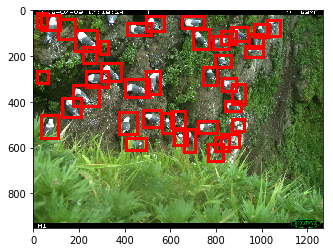

In [51]:
# Compare to full-network prediction
viz_predict_eval_image('kittiwake_labled/test/222.JPG')